In [50]:
import os
import time
import math
import random
import itertools
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from IPython.display import clear_output

# SVM Training Functions

<a href="https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">Guide to SVM Training</a>
### To-do:
<ul>
    <li> Refine grid search, try to increase accuracy of outer loop subjects </li>
    <li> Permutation tests with scrambled label data </li>
    <li> Make data generation process more efficient/less redundant </li>
    <li> Shorten/simplify parameter list </li>
</ul>

In [2]:
def get_subjects(path):
    
    '''
    Gets a list of subject IDs and the file suffix, given a path to the data files. 
    
    Note: subject ID must be only 2 characters for this to work, and all data files
    must have same suffix.
    
    Parameters
    ----------
    path: str
        directory to the data files
        
    Returns
    -------
    list
        a list of subject IDs
    str
        the suffix to the filenames
    '''
    
    files = os.listdir(path)
    subjects = [f[:2] for f in files]
    suffix = files[0][2:]
        
    subjects.sort()
    
    return subjects, suffix

In [183]:
def scramble_labels(y_data, classes):
    
    '''
    Randomly selects half of the labels in the data to switch to the other class.
    
    Parameters
    ----------
    y_data: array-like
        label data to scramble
    classes: list
        the two different classes of labels
    '''
    
    y_data_copy = y_data.copy()
    for index in np.nditer(np.random.choice(len(y_data), size=len(y_data)//2, replace=False)):
        
        if y_data[index] == classes[0]:
            y_data[index] = classes[1]
        else:
            y_data[index] = classes[0]
    
    # Makes sure labels are scrambled properly
    num_diff = sum(i != j for i, j in zip(y_data, y_data_copy))  
    if num_diff != len(y_data)//2:
        raise ValueError
    

In [106]:
def extract_subject_data(path, subject, suffix, roi, conds, block_length, rank_first, shuffle):
    
    '''
    Extracts individual subject data from the .mat files.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)
    block_length: int
        the number of voxels to standardize every block in the dataset to
        
    Returns
    -------
    List of voxel data (x_data) separated by individual blocks and the corresponding labels (y_data)
    '''
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
    
    ranked_indices = None
    
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            for block in range(len(mat[0][scan][0][cond][0])):

                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                    
                if rank_first:
                    if ranked_indices is None:
                        ranked_indices = [i for i in (-np.array(block_data)).argsort()[:block_length]]
                    block_data = [block_data[i] if i < len(block_data) else 0 for i in ranked_indices]
                elif shuffle:
                    random.shuffle(block_data)
                else:
                    # Filters for most active voxels in each block
                    block_data.sort()
                    block_data = block_data[-block_length:]
                
                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0])
    
    data = {'x': x_data, 'y': y_data}
    return data

In [104]:
'''
Generates training and testing data.
'''
def generate_data(subjects, inner_test_subjects, outer_test_subject, path, suffix, roi, conds, block_length, rank_first, shuffle):
    
    '''
    Generates training and testing data, which is separated into training data, inside testing data,
    and outside testind data.
    
    Parameters
    ----------
    subjects: list
        a list of subject IDs to extract data from
    inner_test_subject: list
        list of indices of the inner test subjects
    outer_test_subject: int
        the index of the outer test subject
    path: str
        the path to the data files
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)    
    block_length: int
        the number of voxels to standardize every block in the dataset to
    
    Returns
    -------
    list
        blocks of voxel data for training use
    list
        training labels
    list
        inner test subject blocks of voxel data for testing use
    list 
        testing labels for inner test subject
    list
        outer test subject blocks of voxel data for testing use
    list
        testing labels for outer test subject
    '''
    
    data = []
    
    x_train = []
    y_train = []
    
    x_test_inner = []
    y_test_inner = []
    
    x_test_outer = []
    y_test_outer = []
    
    for subject in subjects:
        
        subject_data = extract_subject_data(path, subject, suffix, roi, conds, block_length, rank_first, shuffle)
        if subject == outer_test_subject:
            x_test_outer.extend(subject_data['x'])
            y_test_outer.extend(subject_data['y'])
        elif subject in inner_test_subjects:
            x_test_inner.extend(subject_data['x'])
            y_test_inner.extend(subject_data['y'])
        else:
            x_train.extend(subject_data['x'])
            y_train.extend(subject_data['y'])
    
    x_train_len = len(x_train)
    x_test_outer_len = len(x_test_outer)
    
    data.extend(x_train)
    data.extend(x_test_outer)
    data.extend(x_test_inner)
    
    # MinMaxScaler scales each feature to values between 0 and 1 among all x data
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_normalized = scaler.fit_transform(data)
    x_train, x_test_outer, x_test_inner = x_normalized[:x_train_len], x_normalized[x_train_len:x_train_len+x_test_outer_len], x_normalized[x_train_len+x_test_outer_len:]

    y_train = np.stack(y_train, axis=0)
    
    return x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer

In [6]:
def get_optimal_run(x_train, y_train, x_test, y_test, kernels, gamma_range, C_range):
    
    '''
    Gets best hyperparameters (kernel, C, and gamma values) that optimize SVM's predictions for given
    x and y test dataset.
    
    Parameters
    ----------
    x_train: array-like
        dataset of block data used to train classifier
    y_train: array-like
        dataset of label data used to train classifier
    x_test: array-like
        testing dataset of block data used to optimize hyperparameters on
    y_test: array-like
        testing dataset of label data used to optimize hyperparameters on
    kernels: list
        kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
    gamma_range: dict
        dict that specifies the range of values of gamma to test; should include start, stop to range,
        num of values, and the exponential base
    C_range: dict
        dict that specifies the range of values of C to test; should include start, stop to range,
        num of values, and the exponential base
        
    Returns
    -------
    dict
        best combination of parameters found from grid search
    float
        best accuracy obtained from testing
    '''
    
    gamma_vals = np.logspace(gamma_range['start'], gamma_range['stop'], gamma_range['num'], base=gamma_range['base'])
    C_vals = np.logspace(C_range['start'], C_range['stop'], C_range['num'], base=C_range['base'])

    param_grid = ParameterGrid({'kernel': kernels, 'gamma': gamma_vals, 'C': C_vals})
    
    best_acc = 0
    best_params = None
    
    # Tests each parameter combination to find best one for given testing data
    for params in list(param_grid):
        
        svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
        svclassifier.fit(x_train, y_train)
        
        curr_acc = svclassifier.score(x_test, y_test)
        
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_params = params
            
    return best_params, best_acc

In [148]:
def train(path, roi, conds, block_length, kernels, gamma_range, C_range, num_inner=1, scramble=False, classes=None, rank_first=True, shuffle=False):
    
    '''
    Trains and tests the classifier for accuracy.
    
    Parameters
    ----------
    path: str
        the path to the data files
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)    
    block_length: int
        the number of voxels to standardize every block in the dataset to
    kernels: list
        kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
    gamma_range: dict
        dict that specifies the range of values of gamma to test; should include start, stop to range,
        num of values, and the exponential base
    C_range: dict
        dict that specifies the range of values of C to test; should include start, stop to range,
        num of values, and the exponential base
    num_inner: int
        number of inner subjects to test classifier on, default is 1
    scramble: boolean, optional
        whether or not to scramble the labels when training, default is False
    classes: list, optional if scramble is False but required if scramble is True
        label classes for the data (should be length of 2)
    rank_first: boolean, optional
        whether to base ordering of block data based on first block for each subject, 
        default is True
    shuffle: boolean, optional
        whether to shuffle the subject data blocks, default is False
        
    Returns
    -------
    DataFrame
        data of inner subject combination testing accuracy
    DataFrame
        data of outer subject testing accuracy
    '''
    
    subjects, suffix = get_subjects(path)
    
    cols = []
    for combo in itertools.combinations(range(len(subjects)), num_inner):
        col = ''
        for subject in combo:
            col += '/' + subjects[subject]
        cols.append(col[1:])

    inner_acc_report = pd.DataFrame(index=subjects, columns=cols)
    outer_acc_report = pd.DataFrame(index=subjects, columns=cols)
    
    for outer_subject in subjects:
        
        print("Currently on outer subject #%i." % (subjects.index(outer_subject)+1))

        start_time = time.time()
        
        inner_subjects = [s for s in subjects if s != outer_subject]
        for inner_subject_test in itertools.combinations((inner_subjects), num_inner):
            
            inner_subject_test = list(inner_subject_test)

            col = ''
            for subject in inner_subject_test:
                col += '/' + subject
            col = col[1:]
            # print("Currently on combination of %s." % (col))    
            
            x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer = generate_data(subjects, inner_subject_test, outer_subject, path, suffix, roi, conds, block_length, rank_first, shuffle)
            
            if scramble:
                scramble_labels(y_train, classes)
                
            # gets optimal params for training dataset from grid search
            params, inner_acc = get_optimal_run(x_train, y_train, x_test_inner, y_test_inner, kernels, gamma_range, C_range) 

            # train model using optimal params for this set
            svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
            svclassifier.fit(x_train, y_train)
            
            outer_acc = svclassifier.score(x_test_outer, y_test_outer)
            
            # logs inner and outer subject accuracy data in dataframe
            inner_acc_report.at[outer_subject, col] = inner_acc
            outer_acc_report.at[outer_subject, col] = outer_acc

        # clear_output()
        
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print('Last turn took %i minutes and %f seconds.' % (minutes, seconds))
    
    clear_output()
    return inner_acc_report, outer_acc_report

# Training Classifier/Visualizing Accuracies

In [98]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 16, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 16, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range, num_inner=1, rank_first=True)

inner_accs.to_csv('output/rank/inner_accs16_rank.csv')
outer_accs.to_csv('output/rank/outer_accs16_rank.csv')

In [93]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 32, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range, num_inner=2, rank_first=True)

inner_accs.to_csv('output/rank/inner_accs32_2inner.csv')
outer_accs.to_csv('output/rank/outer_accs32_2inner.csv')

In [96]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 32, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range, num_inner=3, rank_first=True)

inner_accs.to_csv('output/rank/inner_accs32_3inner.csv')
outer_accs.to_csv('output/rank/outer_accs32_3inner.csv')

In [97]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 32, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range, num_inner=4, rank_first=True)

inner_accs.to_csv('output/rank/inner_accs32_4inner.csv')
outer_accs.to_csv('output/rank/outer_accs32_4inner.csv')

In [59]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 64, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 64, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range)

inner_accs.to_csv('output/inner_accs64.csv', sep='\t')
outer_accs.to_csv('output/outer_accs64.csv', sep='\t')

In [14]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -15, 'stop': 5, 'num': 32, 'base': 2.0}
C_range = {'start': -5, 'stop': 15, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range)

inner_accs.to_csv('output/inner_accs32_more.csv', sep='\t')
outer_accs.to_csv('output/outer_accs32_more.csv', sep='\t')

# Permutations

In [151]:
def permutation(path, roi, conds, block_length, kernels, gamma_range, C_range, inner_dist, outer_dist, runs, classes=None):
    
    for n in range(runs):
        print(f'On run #{n+1}.')
        inner_accs, outer_accs = train(path, roi, conds, block_length, kernels, gamma_range, C_range, num_inner=1, scramble=True, classes=classes, rank_first=True)
        
        vals = []
        for column in inner_accs:
            vals.extend(inner_accs[column].tolist())
        vals = [x for x in vals if str(x) != 'nan']
        inner_dist.extend(vals)
        
        vals = []
        for column in outer_accs:
            vals.extend(outer_accs[column].tolist())
        vals = [x for x in vals if str(x) != 'nan']
        outer_dist.extend(vals)
        

In [109]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 16, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 16, 'base': 2.0}
kernels = ['rbf', 'sigmoid']
classes = ['trained_ip', 'untrained_ip']

inner_dist = []
outer_dist = []

permutation(path, roi, conds, block_length, kernels, gamma_range, C_range, inner_dist, outer_dist, 6, classes)

In [ ]:
classes = ['trained_ip', 'untrained_ip']
permutation(path, roi, conds, block_length, kernels, gamma_range, C_range, inner_dist, outer_dist, 4, classes)

On run #1.
Currently on outer subject #1.
Last turn took 1 minutes and 36.637903 seconds.
Currently on outer subject #2.
Last turn took 1 minutes and 30.621984 seconds.
Currently on outer subject #3.
Last turn took 1 minutes and 35.161240 seconds.
Currently on outer subject #4.
Last turn took 1 minutes and 44.449642 seconds.
Currently on outer subject #5.


(array([  1.,   1.,   7.,   0.,  22.,  12.,  48.,  45., 180.,   0., 281.,
          0., 194.,  53.,  45.,   9.,  30.,   0.,   6.,   2.]),
 array([0.08333333, 0.12291667, 0.1625    , 0.20208333, 0.24166667,
        0.28125   , 0.32083333, 0.36041667, 0.4       , 0.43958333,
        0.47916667, 0.51875   , 0.55833333, 0.59791667, 0.6375    ,
        0.67708333, 0.71666667, 0.75625   , 0.79583333, 0.83541667,
        0.875     ]),
 <a list of 20 Patch objects>)

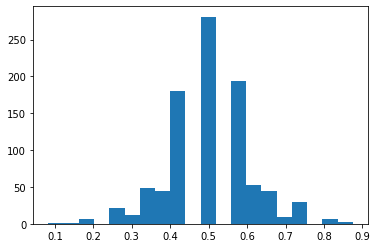

In [114]:
plt.hist(outer_dist, bins=20)

In [115]:
np.mean(outer_dist)

0.5026709401709402

In [119]:
len(outer_dist)

936

In [121]:
np.save('output/permutations/outer_dist16.npy', outer_dist)
np.save('output/permutations/inner_dist16.npy', inner_dist)

# Train with All

In [53]:
def train_with_all(path, roi, conds, block_length, kernels, gamma_range, C_range, scramble=False):
    
    '''
    Trains and tests the classifier for accuracy using entire dataset.
    
    Parameters
    ----------
    path: str
        the path to the data files
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)    
    block_length: int
        the number of voxels to standardize every block in the dataset to
    kernels: list
        kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
    gamma_range: dict
        dict that specifies the range of values of gamma to test; should include start, stop to range,
        num of values, and the exponential base
    C_range: dict
        dict that specifies the range of values of C to test; should include start, stop to range,
        num of values, and the exponential base
    scramble: boolean, optional
        whether or not to scramble the labels when training, default is False
        
    Returns
    -------
    DataFrame
        data of inner subject testing accuracy
    DataFrame
        data of outer subject testing accuracy
    '''
    
    subjects, suffix = get_subjects(path)
    
    inner_acc_report = pd.DataFrame(index=subjects, columns=subjects)
    outer_acc_report = pd.DataFrame(index=subjects, columns=subjects)
    
    for outer_subject in range(len(subjects)):
        
        print("Currently on outer subject #%i." % (outer_subject+1))

        start_time = time.time()
        
        for inner_subject in range(len(subjects)):

            if inner_subject == outer_subject:
                continue

            print("Currently on inner subject #%i." % (inner_subject+1))    
            x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer = generate_data(subjects, inner_subject, outer_subject, path, suffix, roi, conds, block_length)
            
            x_whole = np.vstack((x_train, x_test_inner, x_test_outer))
            y_whole = np.concatenate((y_train, y_test_inner, y_test_outer))
            
            if scramble:
                scramble_labels(y_train, classes)
                
            # gets optimal params for training dataset from grid search
            params, inner_acc = get_optimal_run(x_whole, y_whole, x_test_inner, y_test_inner, kernels, gamma_range, C_range) 
            print('Found best params for current inner subject.')
            
            # train model using optimal params for this set
            svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
            svclassifier.fit(x_whole, y_whole)
            
            print('Testing outer subject...')
            outer_acc = svclassifier.score(x_test_outer, y_test_outer)
            
            # logs inner and outer subject accuracy data in dataframe
            index = subjects[outer_subject]
            col = subjects[inner_subject]
            
            inner_acc_report.at[index, col] = inner_acc
            outer_acc_report.at[index, col] = outer_acc

        clear_output()
        
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print('Last turn took %i minutes and %f seconds.' % (minutes, seconds))
    
    clear_output()
    return inner_acc_report, outer_acc_report

[2, 3, 1, 0]

In [ ]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 32, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

inner_accs, outer_accs = train_with_all(path, roi, conds, block_length, kernels, gamma_range, C_range)